# Solve cartpole with DQN



In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T


env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [3]:
class DQN(nn.Module):

    def __init__(self, h, w, outputs):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1)
        #self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1)
        #self.bn2 = nn.BatchNorm2d(16)
        #self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1)
        #self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(16, 4, kernel_size=3, stride=1)
        #self.bn4 = nn.BatchNorm2d(4)
        
        self.pool = nn.MaxPool2d(2)

        self.head = nn.Linear(204, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        
        x = F.relu(self.pool(self.conv1(x)))
        x = F.relu(self.pool(self.conv2(x)))
        x = F.relu(self.pool(self.conv4(x)))
        return self.head(x.view(x.size(0), -1))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)
        
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


class DQN_basic(nn.Module):
    def __init__(self, h, w, outputs):
        super(DQN_basic, self).__init__()
        self.l1 = nn.Linear(4, 20)
        self.head = nn.Linear(20, outputs)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.l1(x))
        return self.head(x)
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

test = DQN(1, 1, 2)
test(torch.zeros([1, 3, 40, 150]))

tensor([[-0.0280,  0.0104]], grad_fn=<AddmmBackward>)

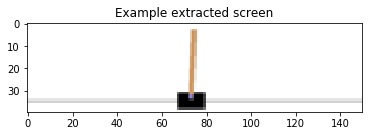

In [4]:
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])


def get_cart_location(screen_width):
    world_width = env.x_threshold * 2
    scale = screen_width / world_width
    return int(env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

def get_screen():
    # Returned screen requested by gym is 400x600x3, but is sometimes larger
    # such as 800x1200x3. Transpose it into torch order (CHW).
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))
    # Cart is in the lower half, so strip off the top and bottom of the screen
    _, screen_height, screen_width = screen.shape
    screen = screen[:, int(screen_height*0.4):int(screen_height * 0.8)]
    view_width = int(screen_width * 0.6)
    cart_location = get_cart_location(screen_width)
    #print(cart_location)
    #if cart_location < view_width // 2:
    #    slice_range = slice(view_width)
    #elif cart_location > (screen_width - view_width // 2):
    #    slice_range = slice(-view_width, None)
    #else:
    #    slice_range = slice(cart_location - view_width // 2,
    #                        cart_location + view_width // 2)
    # Strip off the edges, so that we have a square image centered on a cart
    # screen = screen[:, :, slice_range]
    # Convert to float, rescale, convert to torch tensor
    # (this doesn't require a copy)
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    screen = torch.from_numpy(screen)
    # Resize, and add a batch dimension (BCHW)
    return resize(screen).unsqueeze(0).to(device)

env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()
env.close()

In [5]:
BATCH_SIZE = 128
GAMMA = 0.75
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10
tau = 0.01
MEM_SIZE = 40000
learning_rate = 0.001
past = 3

# Get screen size so that we can initialize layers correctly based on shape
# returned from AI gym. Typical dimensions at this point are close to 3x40x90
# which is the result of a clamped and down-scaled render buffer in get_screen()
init_screen = get_screen()
_, _, screen_height, screen_width = init_screen.shape

# Get number of actions from gym action space
n_actions = env.action_space.n

policy_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net = DQN(screen_height, screen_width, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters(), lr=learning_rate, weight_decay=1e-5)
memory = ReplayMemory(MEM_SIZE)


steps_done = 0

eps = []

def select_action(state, eps_max=1):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    eps_threshold = min(eps_max, eps_threshold)
    eps.append(eps_threshold)
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)


episode_durations = []


mean_max = 100
mean_rewards = []
episode_rewards = []
def plot_rewards():
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.axhline(y=0.0,color='black',linestyle='--')
    while len(mean_rewards) < len(episode_rewards):
        idx = len(mean_rewards)
        start = max(idx-mean_max, 0)
        curr = episode_rewards[start:idx+1]
        mean = sum(curr)/len(curr)
        mean_rewards.append(mean)
    plt.plot(episode_rewards)
    plt.plot(mean_rewards)
    
losses = []
losses_avg = []
def plot_losses():
    plt.title('Losses')
    plt.xlabel('steps')
    plt.ylabel('Loss')
    plt.plot(losses)
    # Take 100 episode averages and plot them too
    avg_length = 100
    while len(losses) > len(losses_avg) + avg_length:
        if len(losses_avg) == 0:
            losses_avg.append(sum(losses[:avg_length])/avg_length)
        else:
            i_rem = len(losses_avg) - 1
            i_add = i_rem + avg_length
            l_curr = losses_avg[-1]
            l_curr += (losses[i_add] - losses[i_rem])/avg_length
            losses_avg.append(l_curr)
    if len(losses_avg) > 0:
        plt.plot(losses_avg)
    
    
def plot_stuff():
    if is_ipython:
        display.clear_output(wait=True)
    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plot_rewards()
    plt.subplot(122)
    plot_losses()
    plt.pause(0.001)

In [6]:
import time
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    optimizer.zero_grad()
    # Compute Huber loss

    # Optimize the model
    torch.cuda.synchronize()
    t0 = time.time()
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    losses.append(loss.item())
    loss.backward()
    
    
    torch.cuda.synchronize()
    t1 = time.time()
    #print(t1 - t0)  
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    

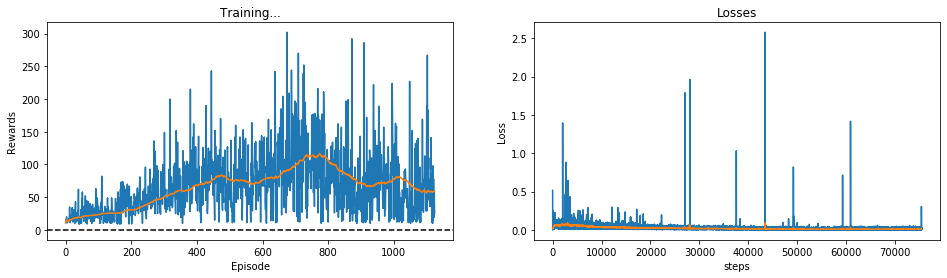

1125
torch.Size([1, 3, 40, 150])


KeyboardInterrupt: 

In [7]:
num_episodes = 50000
for i_episode in range(num_episodes):
    print(i_episode)
    # Initialize the environment and state
    env.reset()
    screen = get_screen()[:,2:3,:,:] # get the blue channel
    screens = [screen]*past
    state = torch.cat(screens, dim=1)
    print(state.shape)
    for t in count():
        # Select and perform an action
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # Observe new state
        screen = get_screen()[:,2:3,:,:]
        del screens[0]
        screens.append(screen)
        if not done:
            next_state = torch.cat(screens, dim=1)
            #print(next_state.shape)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_rewards.append(t + 1)
            plot_stuff()
            break
        
    # Update the target network, copying all weights and biases in DQN
    #break
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
    #target_net.update_params(policy_net.state_dict(), tau)

print('Complete')
env.render()
env.close()
#plot_durations()
#plt.ioff()
#plt.show()


In [ ]:
env.reset()
env.render()
print(len(memory))
done = False
screen = get_screen()[:,2:3,:,:] - 1# get the blue channel
screens = [screen]*past
rgb_screen = get_screen()
rgb_screens = [rgb_screen]*past
print(torch.max(screen))
while not done:
    screen = get_screen()[:,2:3,:,:] - 1
    del screens[0]
    screens.append(screen)
    
    rgb_screen = get_screen()
    del rgb_screens[0]
    rgb_screens.append(rgb_screen)
    
    state = torch.cat(screens, dim=1)
    print(policy_net(state))
    action = select_action(state, eps_max=0)
    _, reward, done, _ = env.step(action.item())
    
env.close()   

for screen in rgb_screens:
    plt.figure()
    plt.imshow(screen.cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
    plt.title('Screen')
    plt.show()

In [ ]:
for name, param in policy_net.named_parameters():
    if param.requires_grad:
        print(name, torch.mean(param.data), torch.std(param.data), torch.max(param.data),)

In [ ]:
policy_net(state).max(0)[1].view(1,1)

In [ ]:
state

In [ ]:
def optimize_model_mine():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.float32)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    rand_state = batch.state[0]
    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    ## state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    #policy_dqn.optimizer.zero_grad()
    next_states = torch.cat([s if s is not None else rand_state for s in batch.next_state])
    Q = policy_net(state_batch).gather(1, action_batch).squeeze()
                
    with torch.no_grad():
        Q1 = target_net(next_states)
                    
    q_targets = reward_batch + GAMMA * Q1.max(dim=1)[0] * (non_final_mask)
                
    #loss = policy_dqn.loss(Q, q_targets)
        
    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    ##next_state_values = torch.zeros(BATCH_SIZE, device=device)
    ##next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    ##expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(Q, q_targets)
    losses.append(loss.cpu().detach().numpy())

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()